In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Question 1

In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

Individual Contributors (IC) - they don't manage anyone

Middle Managers (MM) - they are the direct bosses of IC

Directors (D) - they are the direct bosses of MM

VP - D direct bosses

Executives (E) - VP direct bosses

CEO - The direct boss of E.

In [4]:
hierarchy = pd.read_csv("company_hierarchy.csv",index_col='employee_id')
hierarchy['level'] = None # initialize 

# starting point
hierarchy.loc[hierarchy.dept == 'CEO','level'] = 'CEO'

# change all boss_id to integer
hierarchy.loc[hierarchy.level == 'CEO','boss_id'] = -1
hierarchy['boss_id'] = hierarchy.boss_id.astype(int)

def set_level(boss_level,level):
    boss_ids = hierarchy.loc[hierarchy.level == boss_level,:].index
    is_subordinate = np.in1d(hierarchy.boss_id,boss_ids)
    hierarchy.loc[is_subordinate,'level'] = level

set_level('CEO','E')
set_level('E','VP')
set_level('VP','D')
set_level('D','MM')
set_level('MM','IC')

In [5]:
hierarchy.level.value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

# Question 2

How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [6]:
hierarchy['n_subordinates'] = 0 # initialize

def __count_subordinates(s):
    """
    s: stands for subordinates, it is a series
    its value represents #subordinates that subordinate has
    """
    n_direct_subordinates = s.shape[0]
    n_indirect_subordinates = s.sum()
    return n_direct_subordinates + n_indirect_subordinates

def count_subordinates(subordinate_level):
    num_subordinates = hierarchy.loc[hierarchy.level == subordinate_level,:].groupby('boss_id')['n_subordinates'].agg(__count_subordinates)
    hierarchy.loc[num_subordinates.index,'n_subordinates'] = num_subordinates

count_subordinates(subordinate_level="IC")
count_subordinates(subordinate_level="MM")
count_subordinates(subordinate_level="D")
count_subordinates(subordinate_level="VP")
count_subordinates(subordinate_level="E")

In [7]:
print(hierarchy.head())

             boss_id   dept level  n_subordinates
employee_id                                      
46456         175361  sales    IC               0
104708         29733     HR    IC               0
120853         41991  sales    IC               0
142630        171266     HR    MM              16
72711         198240  sales    IC               0


# Question 3

Build a model to predict the salary of each employee.

### Load all the data

In [8]:
employees = pd.read_csv("employee.csv",index_col="employee_id")

# make the salary "N k", where k represents $1000, which is easier to display
employees["salary"] /= 1000

In [9]:
# join all features together
employees = employees.join(hierarchy)

## Feature Enginnering

In [10]:
X = employees.copy()

X["is_male"] = (X.sex == "M").astype(int)
del X["sex"]

del X['boss_id']# I assume boss_id won't affect salary

In [11]:
# transform 'level' into numbers
# !!! ORDER matters
index2level = ['IC','MM',"D","VP","E","CEO"]
level2index = {l:index for index,l in enumerate(index2level)}
X['level'] = X.level.map(level2index)

In [12]:
# transform 'educational degree' into numbers
# !!! ORDER matters
index2degree = ['High_School','Bachelor','Master','PhD']
degree2index = {d:index for index,d in enumerate(index2degree)}
X['degree'] = X.degree_level.map(degree2index)
del X['degree_level']

In [ ]:
# OHE department
X = pd.get_dummies(X)
del X['dept_CEO']

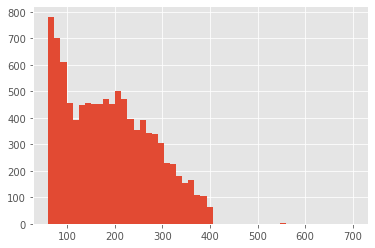

In [14]:
X.salary.hist(bins=50)

from above plot, we can see that, salary's distribution is highly skewed , which increase difficulty on regression. so I need log transform on the target value.


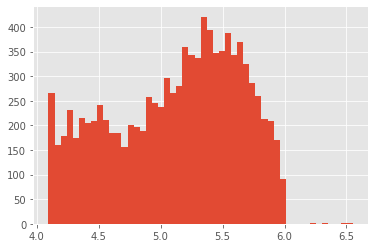

In [15]:
X['salary'] = np.log(X.salary)
X.salary.hist(bins=50)

we can see after log transformation, salary's distribution is more balanced .

### Remove outliers

In [16]:
X.groupby('level')['salary'].agg(['count','mean'])

,count,mean
level,,
0,9000,5.112835
1,800,5.136089
2,160,5.256181
3,35,5.496709
4,4,6.327854
5,1,6.551080


from above result, we can see there is only one CEO, and his salary is much higher than any other employees in this company.

when I split the data into training/test sets, no matter which set contains CEO, his high salary will impact significantly the training or evaluation. so I consider CEO as outlier, and remove it from the data set.

### Train

In [17]:
y = X['salary']
del X['salary']

In [18]:
seed = 999
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=seed)

In [19]:
Xtrain.level.value_counts()

0    6309
1     550
2     115
3      22
4       3
5       1
Name: level, dtype: int64

In [20]:
Xtest.level.value_counts()

0    2691
1     250
2      45
3      13
4       1
Name: level, dtype: int64

we can see that, after splitting, even the smallest group 'level=4' (i.e., Executive level), has representives in ** both ** groups. Hence, the splitting is valid to be used to train and evaluate.

In [21]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

c:\users\danqi\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [22]:
params = {}
params['silent'] = 1
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
# params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[0]	train-rmse:4.18708+0.00291657	test-rmse:4.18706+0.0128712
[1]	train-rmse:3.77247+0.00268121	test-rmse:3.77249+0.0129416
[2]	train-rmse:3.39965+0.0025848	test-rmse:3.39961+0.0128474
[3]	train-rmse:3.06464+0.00241516	test-rmse:3.06455+0.0128518
[4]	train-rmse:2.76358+0.00217217	test-rmse:2.7635+0.0129976
[5]	train-rmse:2.49342+0.0023459	test-rmse:2.49332+0.0128046
[6]	train-rmse:2.25085+0.00210485	test-rmse:2.25072+0.0129124
[7]	train-rmse:2.03334+0.00194608	test-rmse:2.0332+0.0128494
[8]	train-rmse:1.83862+0.00203586	test-rmse:1.83846+0.0127647
[9]	train-rmse:1.66344+0.00178684	test-rmse:1.66334+0.0128875
[10]	train-rmse:1.50703+0.00163242	test-rmse:1.50696+0.0129595
[11]	train-rmse:1.36727+0.00141252	test-rmse:1.3672+0.0130023
[12]	train-rmse:1.24211+0.00121474	test-rmse:1.24208+0.0128895
[13]	train-rmse:1.13086+0.00117633	test-rmse:1.13086+0.0127116
[14]	train-rmse:1.03211+0.00103335	test-rmse:1.03218+0.0126788
[15]	train-rmse:0.944537+0.00116168	test-rmse:0.944712+0.0125441
[16]	

In [23]:
n_best_trees = cv_results.shape[0]
n_best_trees

54

In [24]:
# re-train on all the data
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[0]	train-rmse:4.18674
[1]	train-rmse:3.77215
[2]	train-rmse:3.40092
[3]	train-rmse:3.06592
[4]	train-rmse:2.76476
[5]	train-rmse:2.49422
[6]	train-rmse:2.25221
[7]	train-rmse:2.03396
[8]	train-rmse:1.83873
[9]	train-rmse:1.66388
[10]	train-rmse:1.50734
[11]	train-rmse:1.3674
[12]	train-rmse:1.24225
[13]	train-rmse:1.13127
[14]	train-rmse:1.03231
[15]	train-rmse:0.944156
[16]	train-rmse:0.866299
[17]	train-rmse:0.797942
[18]	train-rmse:0.73805
[19]	train-rmse:0.685284
[20]	train-rmse:0.639375
[21]	train-rmse:0.599668
[22]	train-rmse:0.565491
[23]	train-rmse:0.536255
[24]	train-rmse:0.511374
[25]	train-rmse:0.490136
[26]	train-rmse:0.472235
[27]	train-rmse:0.457113
[28]	train-rmse:0.444342
[29]	train-rmse:0.433796
[30]	train-rmse:0.425103
[31]	train-rmse:0.41784
[32]	train-rmse:0.4118
[33]	train-rmse:0.406865
[34]	train-rmse:0.402641
[35]	train-rmse:0.399318
[36]	train-rmse:0.396544
[37]	train-rmse:0.394156
[38]	train-rmse:0.392113
[39]	train-rmse:0.390573
[40]	train-rmse:0.389196
[41]	

### Evaluate

In [25]:
ytest_pred = gbt.predict(test_matrix, ntree_limit=n_best_trees)
np.sqrt(mean_squared_error(ytest,ytest_pred))

0.392425650022094

we can see that, training RMSE is 0.38, and test set has RMSE 0.39, the difference isn't very high.

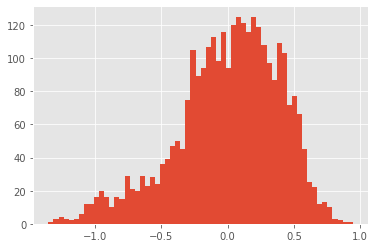

In [26]:
# check residual's distribution
(ytest - ytest_pred).hist(bins=60)

from above plot, we can see residuals' distribution is nearly normal, although a little skewed. Hence, the trained model is acceptable.

In [27]:
gbt.save_model('gbt.model')

## Question 4

Describe the main factors impacting employee salaries.

Do you think the company has been treating its employees fairly? Do you see any bias?

What are the next steps you would suggest to the Head of HR?

### Main factors impacting salaries

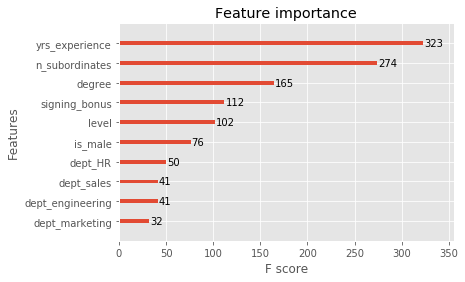

In [28]:
xgb.plot_importance(gbt)

from above plot of feature importance, we can see the main factors impacting salaries includes:

1. "years of experience". this is fair, more experienced deserve high salary
2. 'n_subordinates'. #subordinates has some relationship with level. higher level, more subordinates, more salary

## Residuals Analysis

In [29]:
# predict on all data (except CEO) and calculate the bias
whole_matrix = xgb.DMatrix(X)
ypred = gbt.predict(whole_matrix)

# since our prediction is log(salary), so we need to exp it to get the original salary (unit: k)
predresult = pd.DataFrame({'ytrue': np.exp(y),'ypred': np.exp(ypred)})

# if bias >0, means, that employee is over paid
# otherwise, bias<0, means that employee is under paid
predresult['bias'] = predresult.ytrue - predresult.ypred

In [30]:
# join with employee's features
predresult = predresult.join(employees)
predresult.head() # glance

,ytrue,ypred,bias,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,n_subordinates
employee_id,,,,,,,,,,,,
138719,273.0,216.746994,56.253006,0,273.0,Master,M,2,43602,engineering,IC,0
3192,301.0,168.526306,132.473694,0,301.0,Bachelor,F,1,87847,sales,IC,0
114657,261.0,169.930389,91.069611,0,261.0,Master,F,2,180854,sales,IC,0
29039,86.0,80.813164,5.186836,0,86.0,High_School,F,4,88370,HR,IC,0
118607,126.0,172.799835,-46.799835,0,126.0,Bachelor,F,3,23565,sales,IC,0


In [31]:
del predresult['ytrue'] # redundant with salary

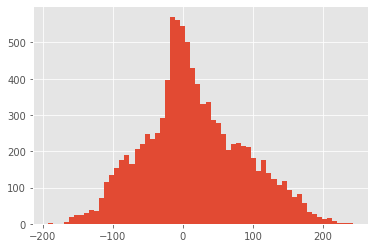

In [32]:
predresult.bias.hist(bins=60)

Text(0, 0.5, 'bias')

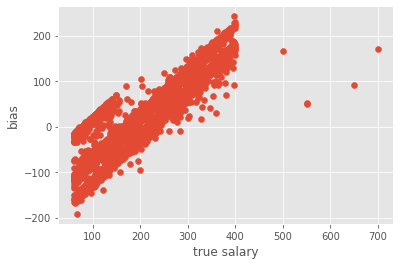

In [33]:
plt.scatter(predresult.salary,predresult.bias)
plt.xlabel("true salary")
plt.ylabel("bias")

In [34]:
def chisquare_test_on_bias():
    X = predresult.copy()
    del X['ypred']
    del X['salary']
    del X['boss_id']

    X['degree_level'] = X.degree_level.map(degree2index)
    X['level'] = X.level.map(level2index)

    X['is_male'] = (X.sex == 'M').astype(int)
    del X['sex']

    dept_lb_encoder = LabelEncoder()
    X['dept'] = dept_lb_encoder.fit_transform(X.dept)
    
    y = (X.bias > 0)
    del X['bias']
    
    scores,pvalues = chi2(X,y)
    return pd.DataFrame({'score': scores, 'pvalue': pvalues},index = X.columns).sort_values(by='pvalue')

In [35]:
chisquare_test_on_bias()

,score,pvalue
n_subordinates,8260.401345,0.000000
dept,12.022876,0.000526
signing_bonus,1.882332,0.170069
is_male,1.105385,0.293087
level,0.546418,0.459785
degree_level,0.380289,0.537449
yrs_experience,0.005327,0.941818


n_subordinates, department, level are three factors impacting whether the employee is overpaid or underpaid.

Text(0, 0.5, 'bias')

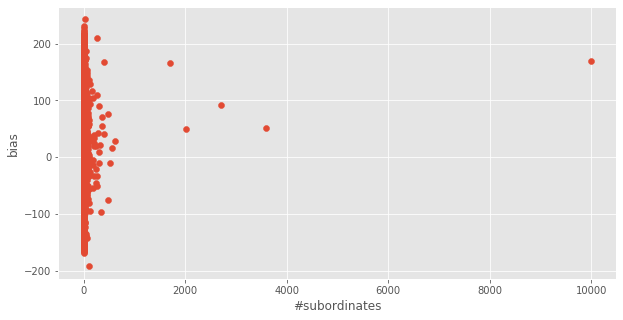

In [36]:
plt.figure(figsize=(10,5))
plt.scatter(predresult.n_subordinates,predresult.bias)
plt.xlabel("#subordinates")
plt.ylabel("bias")

Is it fair? Any bias?

I think, in large scope, the company treat its employee fairly. the difference among different sex and departments seems normal and fair enough.


the only bias I can see is that, the management level is likely to be overpaid. Higher the level, more likely to be overpaid.


Suggestions to HR header
I may suggest him/her considering lower down the salaries in high management level , which may be more fair to the workforce.
